In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 32 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr) #,reformat=False
code.global_options()

# GW convergence analysis for bulk MoS$_2$

We perform a convergence study for the GW runlevel

## HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 12x12x2 k-points sampling.

In [16]:
source_dir = 'BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save/'
run_dir = 'BULK-GW_analysis/kpoints_12x12x2-nbnds_200'

save_dir = Tools.make_p2y(source_dir)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_12x12x2-nbnds_200. No operations performed.


We the define the input variables commmon to all the runs

In [17]:
start_band,stop_band = 52,53 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -x -V all',folder=run_dir)
inp.set_bandRange(start_band,stop_band)
inp

{'args': 'yambo -x -V all',
 'folder': 'BULK-GW_analysis/kpoints_12x12x2-nbnds_200',
 'filename': 'yambo.in',
 'arguments': ['HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [52.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [122371.0, 'Kb'],
  'FFTGvecs': [10313.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'EXXRLvcs': [67069.0, 'RL'],
  'VXCRLvcs': [67069.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'QPkrange': [[1, 38, 52, 53], ''],
  'QPerange': [[1, 38, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [24]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [25]:
#study.runs[0]

In [26]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
delete job_out script: BULK-GW_analysis/kpoints_12x12x2-nbnds_200/job_hf-G-exxrlvcs_20.0.out
delete folder: BULK-GW_analysis/kpoints_12x12x2-nbnds_200/hf-G-exxrlvcs_20.0
run command: mpirun -np 32 yambo -F hf-G-exxrlvcs_20.0.in -J hf-G-exxrlvcs_20.0 -C hf-G-exxrlvcs_20.0
slurm submit:  cd BULK-GW_analysis/kpoints_12x12x2-nbnds_200 ; sbatch job_hf-G-exxrlvcs_20.0.sh
computation hf-G-exxrlvcs_20.0 is running...
delete job_out script: BULK-GW_analysis/kpoints_12x12x2-nbnds_200/job_hf-G-exxrlvcs_10.0.out
delete folder: BULK-GW_analysis/kpoints_12x12x2-nbnds_200/hf-G-exxrlvcs_10.0
run command: mpirun -np 32 yambo -F hf-G-exxrlvcs_10.0.in -J hf-G-exxrlvcs_10.0 -C hf-G-exxrlvcs_10.0
slurm submit:  cd BULK-GW_analysis/kpoints_12x12x2-nbnds_200 ; sbatch job_hf-G-exxrlvcs_10.0.sh
computation hf-G-exxrlvcs_10.0 is running...
computation hf-G-exxrlvcs_20.0 ended
Run perf

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [27]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([7.2414629999999995, 7.281037, 7.283065000000001, 7.283011],
 [6.460787, 6.396317, 6.393872, 6.3940660000000005])

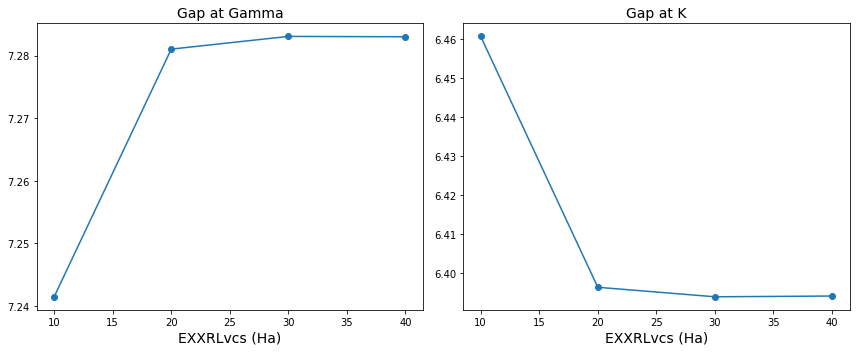

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 20 Ha

## HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [4]:
start_band,stop_band = 52,53 # bands range for the computation of the HF corrections
Gamma_index = {'12x12x2':1,'18x18x3':1,'24x24x4':1}
K_index = {'12x12x2':37,'18x18x3':73,'24x24x4':181}

EXXRLvcs = 20. # Ha
EXXRLVcs_units = 'Ha'

In [5]:
kpoints = ['12x12x2','18x18x3','24x24x4']

In [6]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = 'BULK-DFT_analysis/kpoints_%s-nbnds_200.save'%k
    run_dir = 'BULK-GW_analysis/kpoints_%s-nbnds_200'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)
    
    inp = I.YamboInput(args='yambo -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.32') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 2 parallel tasks
SAVE folder BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_12x12x2-nbnds_200. No operations performed.
SAVE folder BULK-DFT_analysis/kpoints_18x18x3-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_18x18x3-nbnds_200. No operations performed.
Executing command: cd BULK-DFT_analysis/kpoints_24x24x4-nbnds_200.save; p2y
Create folder path BULK-GW_analysis/kpoints_24x24x4-nbnds_200
Create a symlink of BULK-DFT_analysis/kpoints_24x24x4-nbnds_200.save/SAVE in BULK-GW_analysis/kpoints_24x24x4-nbnds_200
Build the r_setup in the run_dir path BULK-GW_analysis/kpoints_24x24x4-nbnds_200


In [9]:
study.runs[5]

{'label': 'Dataset',
 'run_dir': 'BULK-GW_analysis/kpoints_24x24x4-nbnds_200',
 'num_tasks': 2,
 'verbose': True,
 'input': {'args': 'yambo -x -V all',
  'folder': 'BULK-GW_analysis/kpoints_24x24x4-nbnds_200',
  'filename': 'yambo.in',
  'arguments': ['HF_and_locXC'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [52.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [743892.0, 'Kb'],
   'FFTGvecs': [10313.0, 'RL'],
   'SE_Threads': [0.0, ''],
   'EXXRLvcs': [20.0, 'Ha'],
   'VXCRLvcs': [20.0, 'Ha'],
   'DBsIOoff': 'none',
   'DBsFRAGpm': 'none',
   'PAR_def_mode': 'balanced',
   'QPkrange': [[181, 181, 52, 53], ''],
   'QPerange': [[1, 231, 0.0, '-1.000000'], ''],
   'SE_ROLEs': 'q.qp.b',
   'SE_CPU': '1.1.32'}},
 'jobname': 'hf-K-kpoints_24x24x4',
 'name': 'hf-K-kpoints_24x24x4'}

In [10]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
Skip the run of hf-G-kpoints_12x12x2Skip the run of
 hf-K-kpoints_12x12x2
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-kpoints_18x18x3Skip the run of
 hf-K-kpoints_18x18x3
Task [2, 3] ended 
 
Run the task [4, 5] 
run command: mpirun -np 32 yambo -F hf-K-kpoints_24x24x4.in -J hf-K-kpoints_24x24x4 -C hf-K-kpoints_24x24x4
slurm submit:  cd BULK-GW_analysis/kpoints_24x24x4-nbnds_200 ; sbatch job_hf-K-kpoints_24x24x4.sh
computation hf-K-kpoints_24x24x4 is running...
run command: mpirun -np 32 yambo -F hf-G-kpoints_24x24x4.in -J hf-G-kpoints_24x24x4 -C hf-G-kpoints_24x24x4
slurm submit:  cd BULK-GW_analysis/kpoints_24x24x4-nbnds_200 ; sbatch job_hf-G-kpoints_24x24x4.sh
computation hf-G-kpoints_24x24x4 is running...
computation hf-G-kpoints_24x24x4 ended
Run performed in 29s
computation hf-K-kpoints_24x24x4 ended
Run performed in 31s
Task [4, 5] ended 
 


In [11]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([7.281037, 7.332284, 7.359694], [6.396317, 6.434833, 6.459987])

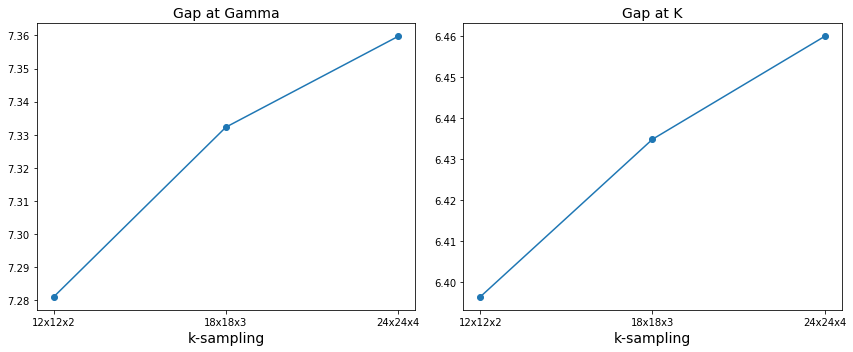

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
#axes[0].set_ylim(8.54,8.58)
#axes[1].set_ylim(6.34,6.38)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

We observe the trend of the HF gap w.r.t. the k-points sampling. A full convergence should require a higher sampling,
however we are not interested in the full convergence of the GW results in this stage of the analysis.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ and at $K$ using the plasmon pole run level. 

The aim of this analysis is to find a converged expression for the screening (that will be used also in the BSE calculations).

### Convergence analysis of the screening

We use the 12x12x2 k-points sampling and perform a convergence analysis in the parameters needed to compute the screening function.

In [6]:
source_dir = 'BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save'
run_dir = 'BULK-GW_analysis/kpoints_12x12x2-nbnds_200'

save_dir = Tools.make_p2y(source_dir)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_12x12x2-nbnds_200. No operations performed.


We the define the input variables commmon to all the runs

In [7]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 52,53
Gamma_index, K_index = 1, 37


EXXRLvcs = 20. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)

inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

16 2


We run over NGsBlkXp, instead we set the number of bands to the maximum value (200) for both the
BndsRnXp and GbndRnge parameters and we do not perform a convergence run on these parameters.

In [8]:
NGsBlkXp = [2.0,4.0,6.0,8.0,10.0] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,200] # Bands in the response function
GbndRnge = [1,200]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_dipoles-nbnds_200','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])])
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_dipoles-nbnds_200','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])])

Initialize a Dataset with 4 parallel tasks


In [43]:
#study.runs[6]

In [9]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of pp-G-ngsblkxp_2.0-bndsrnxp_200-gbndrnge_200Skip the run of
 Skip the run ofpp-K-ngsblkxp_2.0-bndsrnxp_200-gbndrnge_200
 pp-G-ngsblkxp_4.0-bndsrnxp_200-gbndrnge_200
Skip the run of pp-K-ngsblkxp_4.0-bndsrnxp_200-gbndrnge_200
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of Skip the run ofpp-G-ngsblkxp_6.0-bndsrnxp_200-gbndrnge_200
 Skip the run ofpp-K-ngsblkxp_6.0-bndsrnxp_200-gbndrnge_200 
pp-G-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_200
run command: mpirun -np 32 yambo -F pp-K-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_200.in -J "pp-K-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_200,ndb_dipoles-nbnds_200,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200" -C pp-K-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_200
slurm submit:  cd BULK-GW_analysis/kpoints_12x12x2-nbnds_200 ; sbatch job_pp-K-ngsblkxp_8.0-bndsrnxp_200-gbndrnge_200.sh
computation pp-K-ngsblkx

In [10]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([2.600989, 2.657378, 2.673218, 2.679473, 2.686292],
 [2.3545059999999998, 2.348748, 2.364477, 2.367651, 2.3693400000000002])

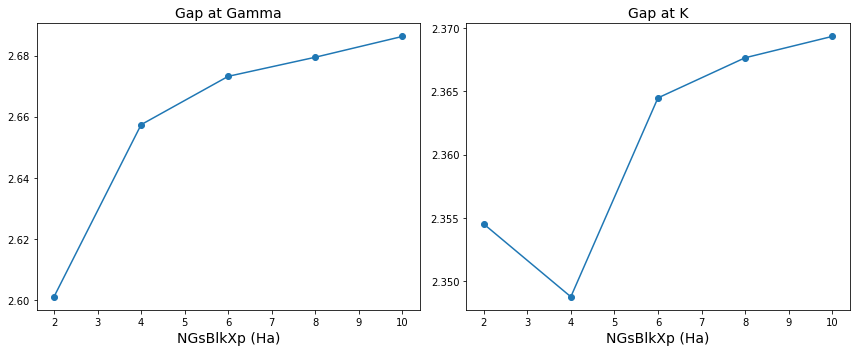

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we observe that NGsBlkXp = 8 Ha ensures convergence at the level of 10-20 meV.

### PP Analysis in function of the k-points sampling

We test the convergence of the PP gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

We compare the results achieved with and without the usage of the RIM_W integration.

In [14]:
kpoints = ['12x12x2','18x18x3','24x24x4']

In [16]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 52,53
Gamma_index = {'12x12x2':1,'18x18x3':1,'24x24x4':1}
K_index = {'12x12x2':37,'18x18x3':73,'24x24x4':181}
EXXRLvcs = 20. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,200]# Bands in the response function
GbndRnge = [1,200] # Bands in the Sigma_c

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = 'BULK-DFT_analysis/kpoints_%s-nbnds_200.save'%k
    run_dir = 'BULK-GW_analysis/kpoints_%s-nbnds_200'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

    inp = I.YamboInput(args='yambo -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_bandRange(start_band,stop_band)
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    
    # append run at G
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    idd = 'pp-G-kpoints_%s'%k
    jobname = [idd,'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_200']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname)
    
    # append run at K
    inp.set_kRange(K_index[k],K_index[k])
    idd = 'pp-K-kpoints_%s'%k
    jobname = [idd,'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-bnds_200']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname)

16 2
Initialize a Dataset with 2 parallel tasks
SAVE folder BULK-DFT_analysis/kpoints_12x12x2-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_12x12x2-nbnds_200. No operations performed.
SAVE folder BULK-DFT_analysis/kpoints_18x18x3-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_18x18x3-nbnds_200. No operations performed.
SAVE folder BULK-DFT_analysis/kpoints_24x24x4-nbnds_200.save/SAVE already present. No operations performed.
SAVE folder already present in BULK-GW_analysis/kpoints_24x24x4-nbnds_200. No operations performed.


In [17]:
study.ids

['pp-G-kpoints_12x12x2',
 'pp-K-kpoints_12x12x2',
 'pp-G-kpoints_18x18x3',
 'pp-K-kpoints_18x18x3',
 'pp-G-kpoints_24x24x4',
 'pp-K-kpoints_24x24x4']

In [19]:
study.runs[4]

{'label': 'Dataset',
 'run_dir': 'BULK-GW_analysis/kpoints_24x24x4-nbnds_200',
 'num_tasks': 2,
 'verbose': True,
 'input': {'args': 'yambo -k hartee -dyson n -gw0 p -V all',
  'folder': 'BULK-GW_analysis/kpoints_24x24x4-nbnds_200',
  'filename': 'yambo.in',
  'arguments': ['em1d', 'gw0', 'HF_and_locXC', 'ppa', 'ExtendOut'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [52.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [743892.0, 'Kb'],
   'FFTGvecs': [10313.0, 'RL'],
   'X_and_IO_nCPU_LinAlg_INV': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'DIP_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'EXXRLvcs': [20.0, 'Ha'],
   'VXCRLvcs': [20.0, 'Ha'],
   'XfnQP_INTERP_NN': [1.0, ''],
   'XfnQP_INTERP_shells': [20.0, ''],
   'XfnQP_Wv_E': [0.0, 'eV'],
   'XfnQP_Wv_dos': [0.0, 'eV'],
   'XfnQP_Wc_E': [0.0, 'eV'],
   'XfnQP_Wc_dos': [0.0, 'eV'],
   'NGsBlkXp': [8.0, 'Ha'],
   'CGrdSpXp': [100.0

In [ ]:
results = study.run(selection=[2,4])

Run the selection [2, 4] with the parallel task_groups [[2, 4]] 

Run the task [2, 4] 
run command: mpirun -np 32 yambo -F pp-G-kpoints_18x18x3.in -J "pp-G-kpoints_18x18x3,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200,ndb_dipoles-bnds_200" -C pp-G-kpoints_18x18x3
slurm submit:  cd BULK-GW_analysis/kpoints_18x18x3-nbnds_200 ; sbatch job_pp-G-kpoints_18x18x3.sh
computation pp-G-kpoints_18x18x3 is running...
run command: mpirun -np 32 yambo -F pp-G-kpoints_24x24x4.in -J "pp-G-kpoints_24x24x4,ndb_em1d-ngsblkxp_8.0-bndsrnxp_200,ndb_dipoles-bnds_200" -C pp-G-kpoints_24x24x4
slurm submit:  cd BULK-GW_analysis/kpoints_24x24x4-nbnds_200 ; sbatch job_pp-G-kpoints_24x24x4.sh
computation pp-G-kpoints_24x24x4 is running...


In [9]:
results_G = [results[r] for r in [0,4,8]]
results_G_rimw = [results[r] for r in [1,5,9]]
results_K = [results[r] for r in [2,6,10]]
results_K_rimw = [results[r] for r in [3,7,11]]

In [11]:
gap_G, gap_G_rimw = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_G_rimw.append(results_G_rimw[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))

gap_K, gap_K_rimw = [],[]
for ind,k in enumerate(kpoints):
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
    gap_K_rimw.append(results_K_rimw[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_K, gap_K_rimw

([3.088822, 2.894613, 2.822524], [2.7199869999999997, 2.713771, 2.713503])

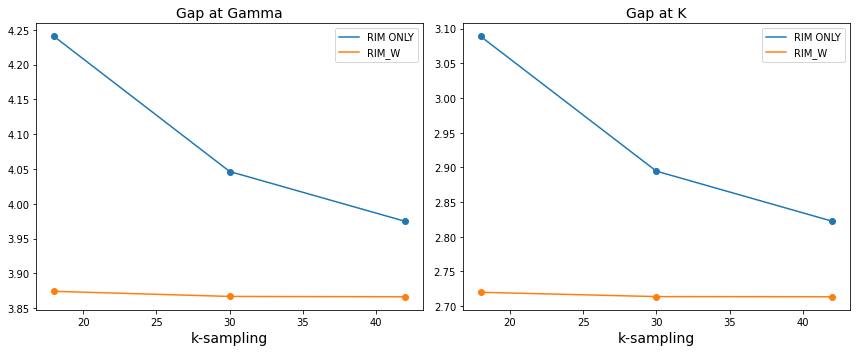

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints, gap_G,label='RIM ONLY')
axes[0].scatter(kpoints,gap_G)
axes[0].plot(kpoints, gap_G_rimw,label='RIM_W')
axes[0].scatter(kpoints,gap_G_rimw)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K,label='RIM ONLY')
axes[1].scatter(kpoints,gap_K)
axes[1].plot(kpoints, gap_K_rimw,label='RIM_W')
axes[1].scatter(kpoints,gap_K_rimw)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
axes[0].legend()
axes[1].legend()
fig.tight_layout()

On the basis of this analysis we see that the usage of the RIM_W interpolation ensures a faster convergence
of the plasmon-pole correction in function of the $k$-points sampling.

## Quasi-particle band structure

We use the convergence test performed above to computed the GW correction in the whole BZ. 
In this way we can compute the quasi-particle correction of the band structure.

At this level of the analysis we perform these computations for 18x18x1 and 30x30x1 $k$-points samplings.

In [87]:
kpoints = 30 # 18 30
run_dir = 'GW_analysis/kpoints_%s-nbnds_250'%kpoints

In [58]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 23,30
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,250]# Bands in the response function
GbndRnge = [1,250] # Bands in the Sigma_c

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

16 1


In [59]:
idd = 'pp-allBZ-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
jobname = [idd,'ndb_rim_cutoff','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),
           'ndb_dipoles-bnds_250','ndb_hf_allBZ']
results = code.run(input=inp,run_dir=run_dir,name=idd,jobname=jobname,reformat=False)

Skip the run of pp-allBZ-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250


### Ypp analysis

We use the previous results to compute the GW correction of the band structure along a high symmetry path.

In [88]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [89]:
ndbQP = 'pp-allBZ-ngsblkxp_6.0-bndsrnxp_250-gbndrnge_250/ndb.QP'

In [90]:
# with BANDS_kpts

band_range = [start_band,stop_band]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step,BANDS_kpts=path)
inp.set_array_variables(GfnQP_E=GfnQP_E[k])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_dft_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [20,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [20,'']
study.append_run(id=idd,input=inp,runner=ypp_code) 

idd = 'ypp_bands_gw_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=ypp_code)

Initialize a Dataset with 2 parallel tasks


In [91]:
#study.runs[1]

In [92]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
run command: mpirun -np 16 ypp -F ypp_bands_gw_boltz.in -J ypp_bands_gw_boltz -C ypp_bands_gw_boltz
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250 ; sbatch job_ypp_bands_gw_boltz.sh
computation ypp_bands_gw_boltz is running...
run command: mpirun -np 16 ypp -F ypp_bands_dft_boltz.in -J ypp_bands_dft_boltz -C ypp_bands_dft_boltz
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250 ; sbatch job_ypp_bands_dft_boltz.sh
computation ypp_bands_dft_boltz is running...
computation ypp_bands_dft_boltz ended
Run performed in 10s
computation ypp_bands_gw_boltz ended
Run performed in 11s
Task [0, 1] ended 
 


In [93]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'MoS$_2$ GW bands')

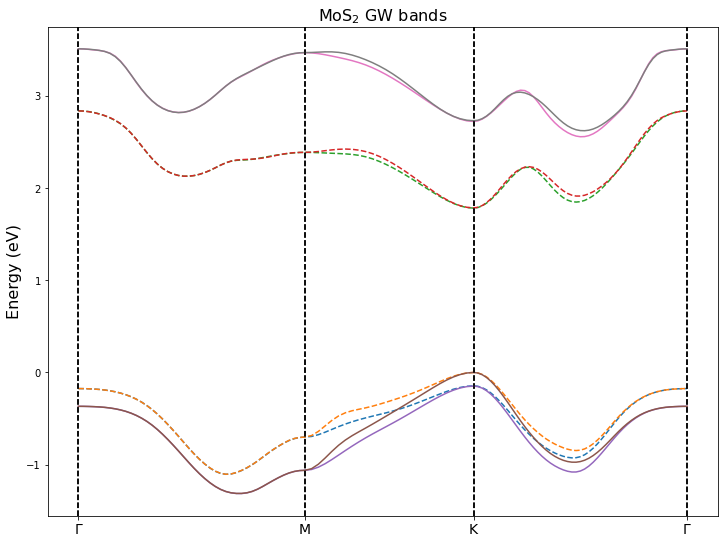

In [86]:
# Results for the 18x18x1 kpoints sampling 

fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[2,3,4,5],linestyle='--',label='dft')
bands_gw.plot(plt,selection=[2,3,4,5],linestyle='-',label='gw')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ GW bands',size=16)

Text(0.5, 1.0, 'MoS$_2$ GW bands')

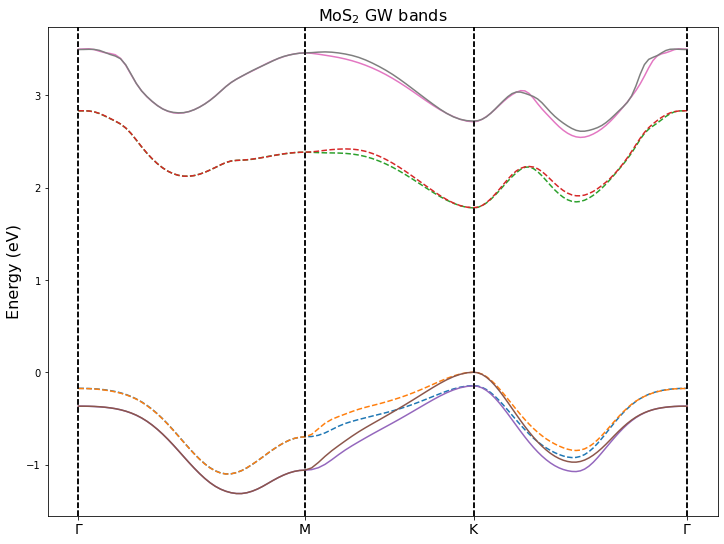

In [94]:
# Results for the 30x30x1 kpoints sampling 

fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[2,3,4,5],linestyle='--',label='dft')
bands_gw.plot(plt,selection=[2,3,4,5],linestyle='-',label='gw')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ GW bands',size=16)